In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import optuna

import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# ****Data Loading

In [2]:
data = pd.read_csv('../input/students-performance-in-exams/StudentsPerformance.csv')
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [4]:
data.duplicated().sum()

0

In [5]:
data.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


# ****Feature Engineering

In [7]:
data['Percentage'] = round((data['reading score'] + data['writing score'] + data['math score']) / 3, 2)

In [8]:
def Grade(percentage):
    if percentage >= 95: return "O"
    if percentage > 81 : return "A"
    if percentage > 71 : return "B"
    if percentage > 61 : return "C"
    if percentage > 51 : return "D"
    if percentage > 41 : return "E"
    else: return "F"

data["Grade"] = data['Percentage'].apply(lambda x: Grade(x))

In [9]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Percentage,Grade
0,female,group B,bachelor's degree,standard,none,72,72,74,72.67,B
1,female,group C,some college,standard,completed,69,90,88,82.33,A
2,female,group B,master's degree,standard,none,90,95,93,92.67,A
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.33,E
4,male,group C,some college,standard,none,76,78,75,76.33,B


# ****Exploratory Data Analysis

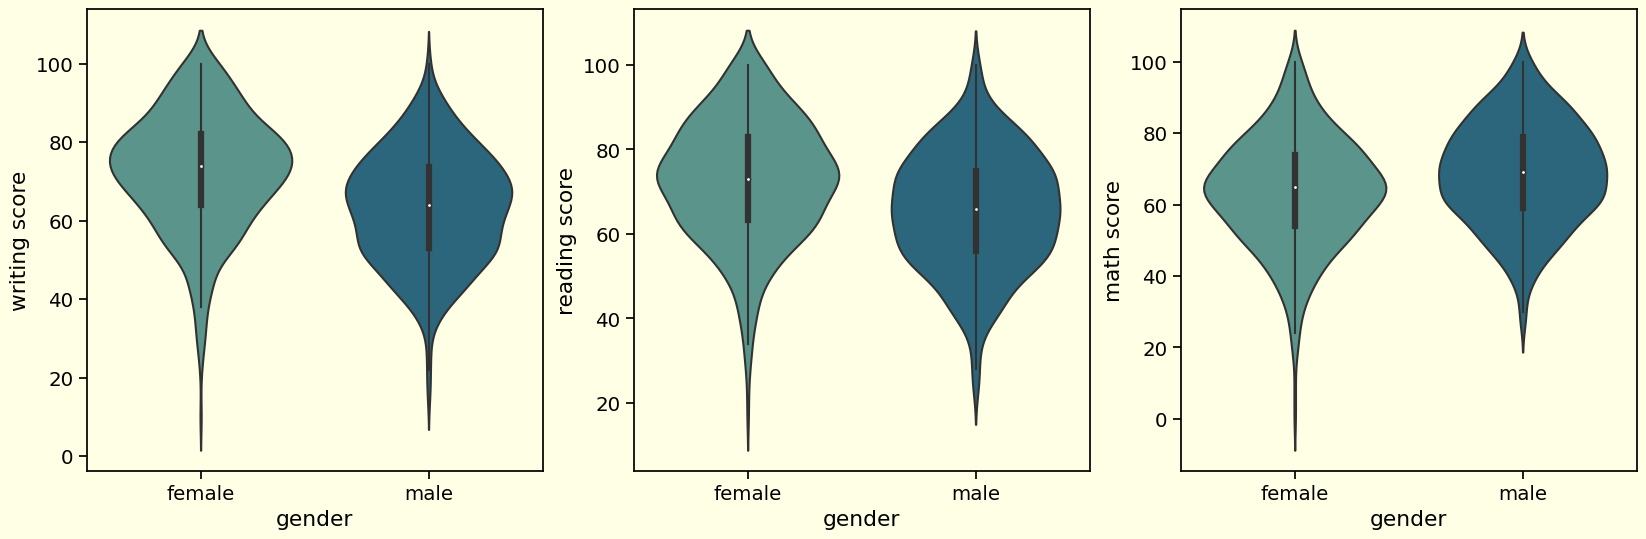

In [10]:
sns.set_context('notebook', font_scale= 1.3)
plt.rcParams['figure.facecolor'] = "#ffffe6"
plt.rcParams['axes.facecolor'] = "#ffffe6"
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
ax1 = sns.violinplot(x = data['gender'], y = data['writing score'], palette= 'crest', ax= ax[0])
ax1 = sns.violinplot(x = data['gender'], y = data['reading score'], palette= 'crest', ax= ax[1])
ax1 = sns.violinplot(x = data['gender'], y = data['math score'], palette= 'crest', ax= ax[2])

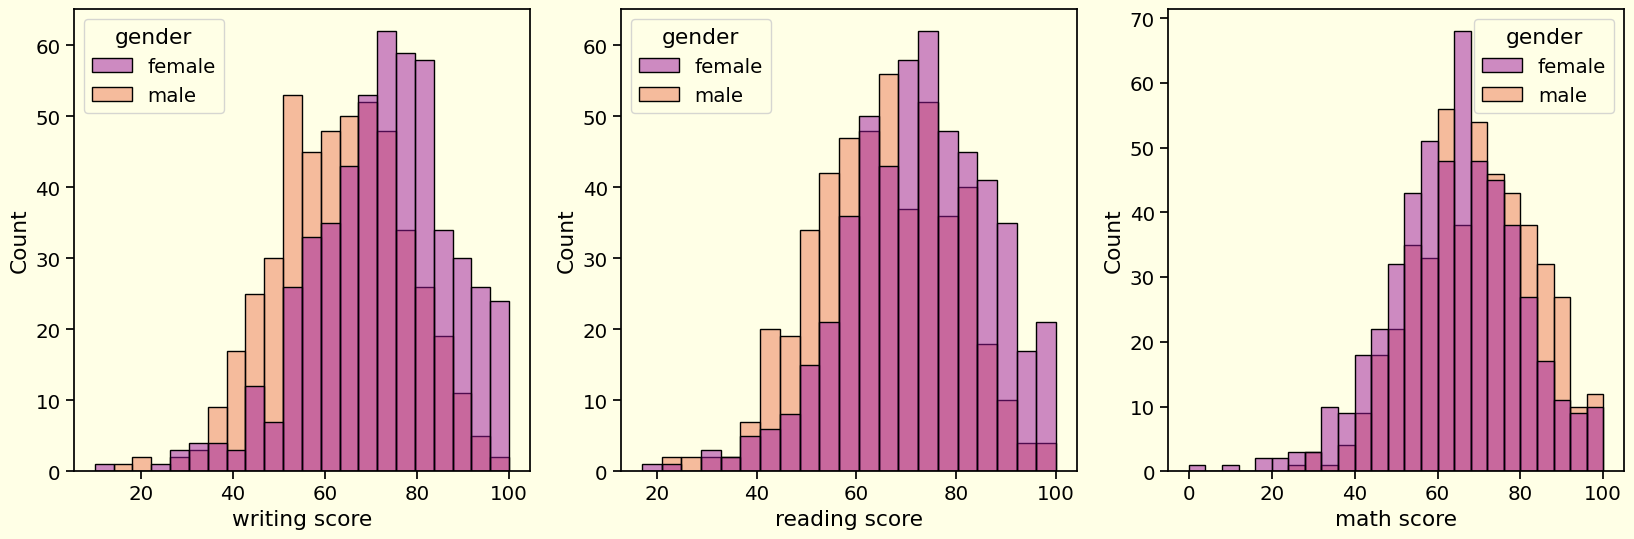

In [11]:
sns.set_context('notebook', font_scale= 1.3)
plt.rcParams['figure.facecolor'] = "#ffffe6"
plt.rcParams['axes.facecolor'] = "#ffffe6"
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
ax1 = sns.histplot(x = data['writing score'], hue = data['gender'] , palette= 'plasma', ax= ax[0])
ax1 = sns.histplot(x = data['reading score'], hue = data['gender'], palette= 'plasma', ax= ax[1])
ax1 = sns.histplot(x = data['math score'], hue = data['gender'], palette= 'plasma', ax= ax[2])

In [12]:
gender_mean_score = data.groupby('gender')[['math score', 'reading score', 'writing score']].mean().round(2).transpose()
fig = go.Figure(data = [
    go.Table(
        header = {
            'values': ['', '<b>Male</b>', '<b>Female</b>'],
            'line_color' : 'darkslategrey',
            'fill_color' : 'lightskyblue',
            'align' : 'center',
            'height' : 40,
            'font_size': 20
        },
        cells = {
            'values' : [gender_mean_score.index, gender_mean_score['male'], gender_mean_score['female']],
            'line_color' : 'darkslategrey',
            'fill_color' : 'lightcyan',
            'align' : 'center',
            'height' : 40,
            'font_size': 20
        }
    )
])

fig.update_layout(width = 600, height = 400)
fig.show()

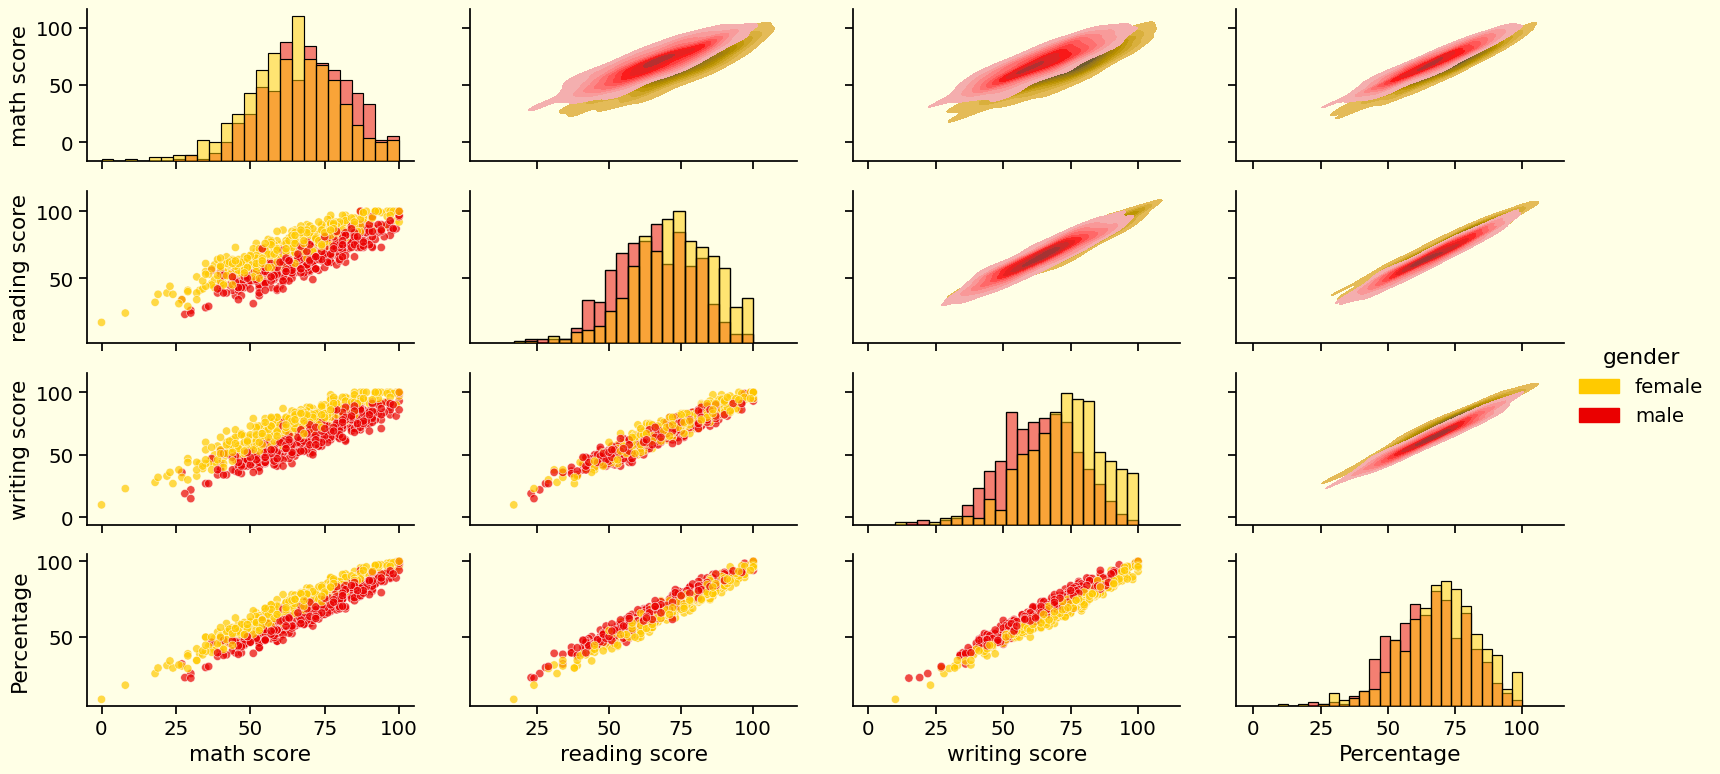

In [13]:
plt.rcParams['figure.facecolor'] = "#ffffe6"
plt.rcParams['axes.facecolor'] = "#ffffe6"

grid = sns.PairGrid(data, vars=['math score', 'reading score', 'writing score', 'Percentage'], hue= 'gender', palette= 'hot_r',
                    height=2, aspect = 2)

grid = grid.map_diag(sns.histplot)
grid = grid.map_lower(sns.scatterplot, alpha =  0.7)
grid = grid.map_upper(sns.kdeplot, n_levels = 10, shade = True)

grid.add_legend()
plt.show()

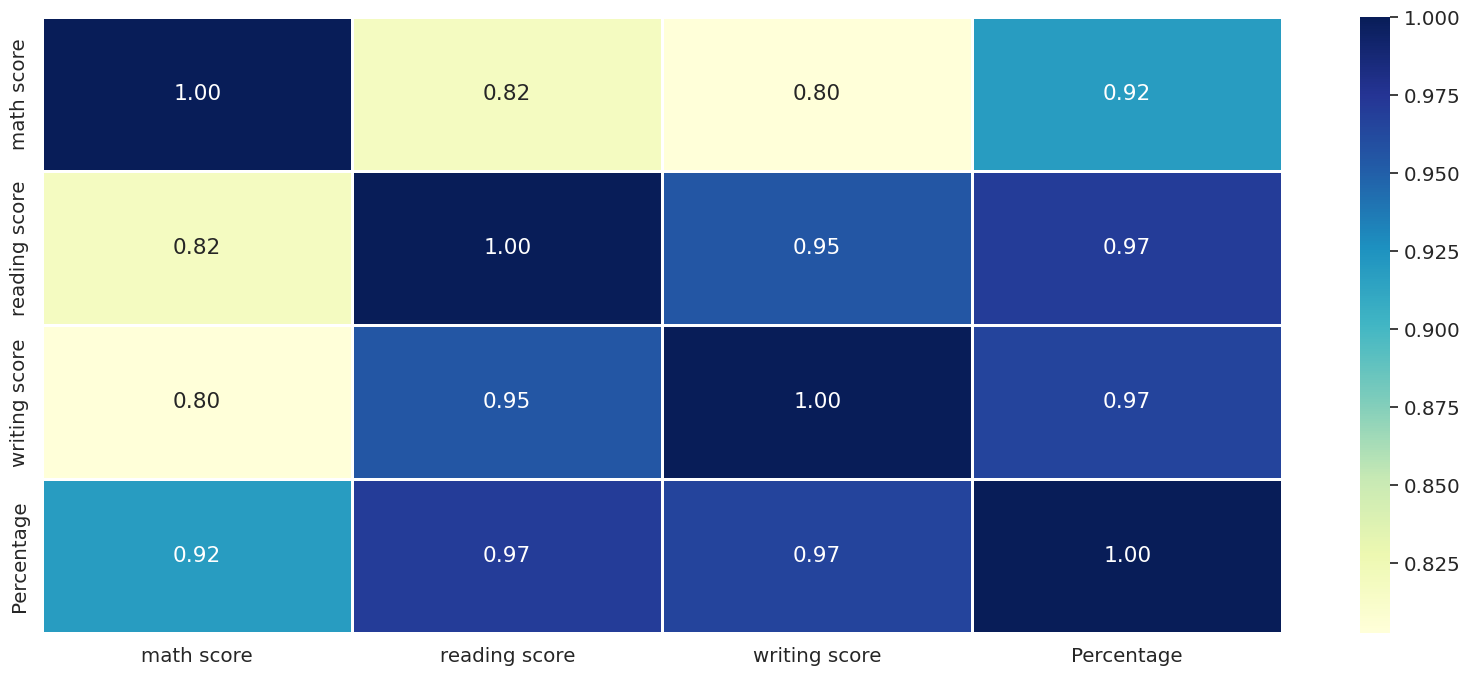

In [14]:
with sns.axes_style('white'):
    plt.figure(figsize= (20, 8))
    sns.heatmap(data.corr(), annot = True, fmt = '.2f', linewidths= 0.8, cmap="YlGnBu")

- Almost all of these scores are highly correlated with each other
- Maths score seems to be the least correlated among these, therefore we will try to predict maths score during modelling

In [15]:
ethnicity = data['race/ethnicity'].value_counts()
fig = px.pie(values = ethnicity.values,
             names = ethnicity.index,
             color_discrete_sequence = px.colors.sequential.Sunset,
             title = "Race/Ethnicity distribution",
             hole = 0.8)
 
fig.update_traces(textinfo = 'label+percent', textfont_size=18)

fig.update_layout(
    font = dict(size = 20, family = "arial"),
    annotations = [dict(text = 'Race', x = 0.5, y = 0.5, font_size = 30, showarrow=False)]
)
fig.show()

In [16]:
parental_education = data['parental level of education'].value_counts()
fig = px.pie(values = parental_education.values,
             names = parental_education.index,
             color_discrete_sequence = px.colors.sequential.Sunset,
             title = "Parental Level Of Education",
             hole = 0.8)
 
fig.update_traces(textinfo = 'label+percent', textfont_size=14)

fig.update_layout(
    font = dict(size = 15, family = "arial"),
    annotations = [dict(text = "Parent's Education", x = 0.5, y = 0.5, font_size = 20, showarrow=False)]
)
fig.show()

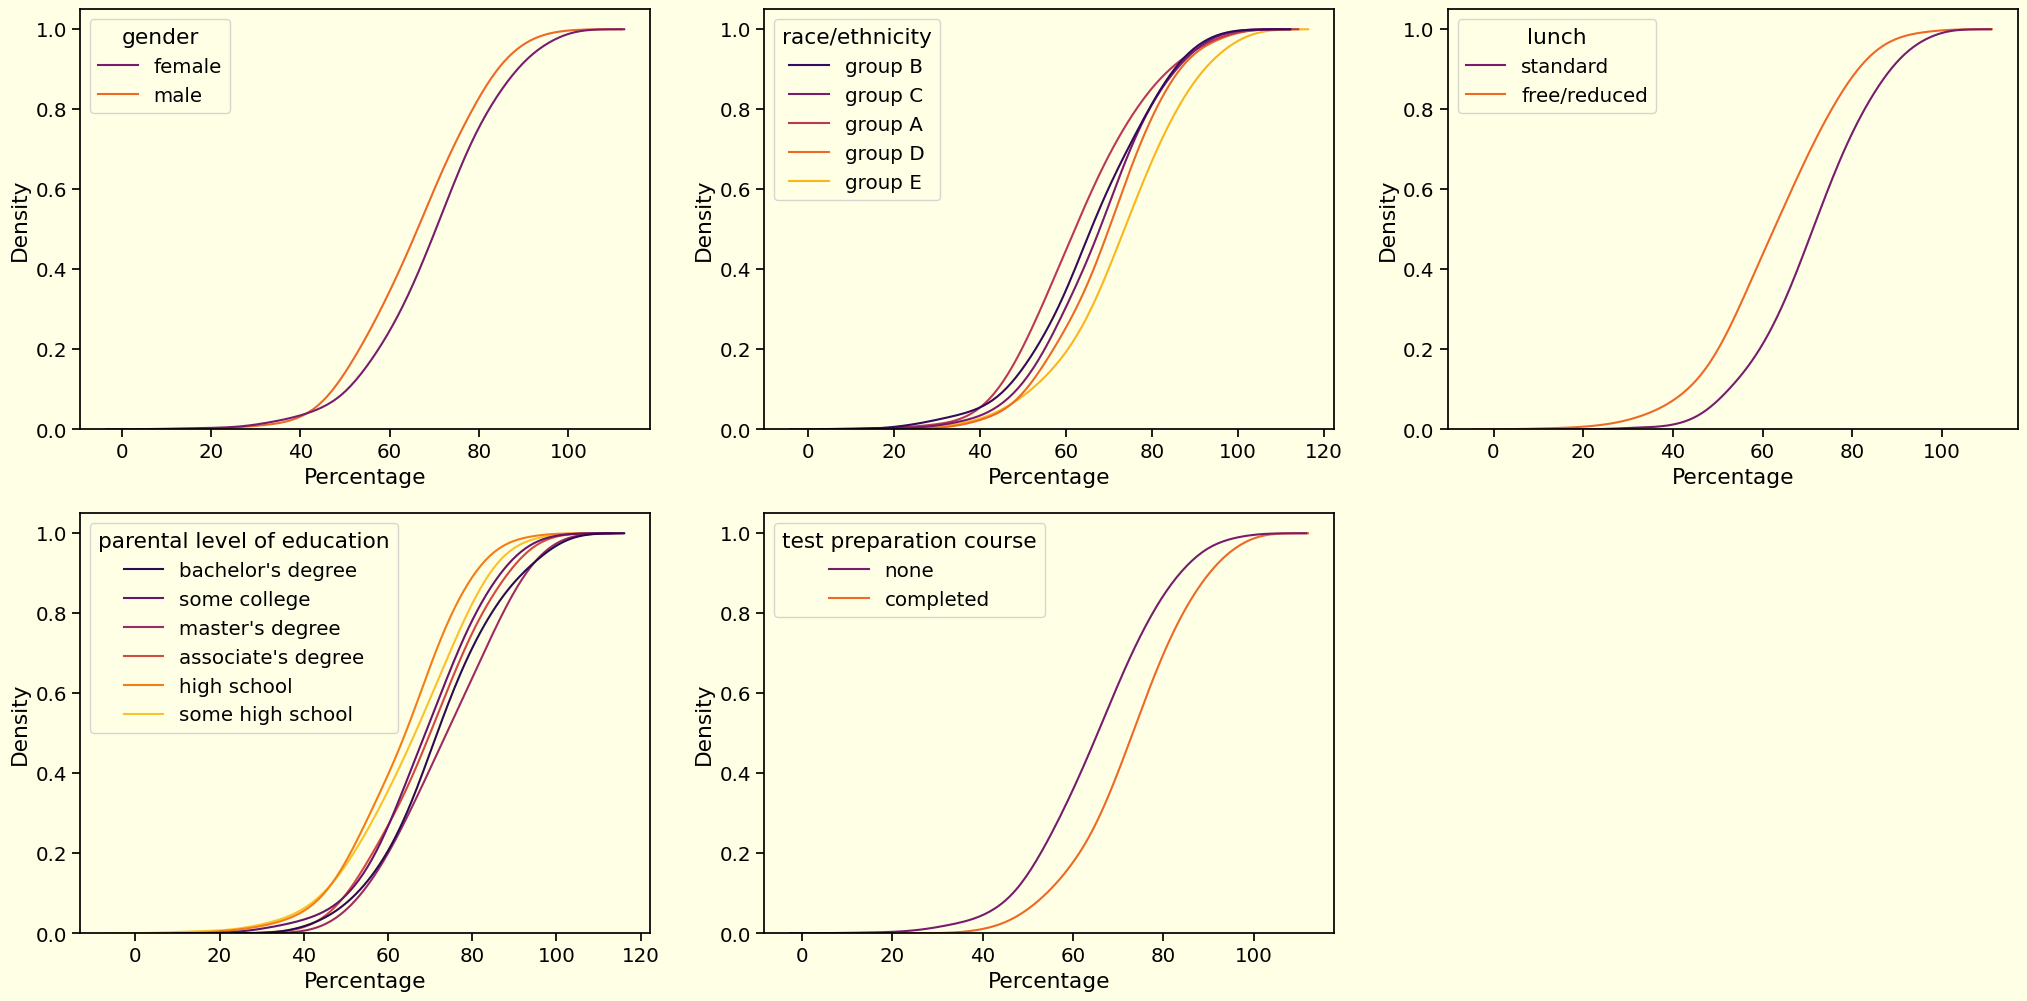

In [17]:
plt.rcParams['figure.facecolor'] = "#ffffe6"
plt.rcParams['axes.facecolor'] = "#ffffe6"

fig, ax = plt.subplots(2, 3, figsize = (25, 12))
ax[1, 2].axis('off')

sns.kdeplot(data = data, x = "Percentage", hue = "gender", palette = 'inferno', cumulative = True, common_norm = False, ax = ax[0, 0])
sns.kdeplot(data = data, x = "Percentage", hue = "race/ethnicity", palette = 'inferno', cumulative = True, common_norm = False, ax = ax[0, 1])
sns.kdeplot(data = data, x = "Percentage", hue = "lunch", palette = 'inferno', cumulative = True, common_norm = False, ax = ax[0, 2])
sns.kdeplot(data = data, x = "Percentage", hue = "parental level of education", palette = 'inferno', cumulative = True, common_norm = False, ax = ax[1, 0])
sns.kdeplot(data = data, x = "Percentage", hue = "test preparation course", palette = 'inferno', cumulative = True, common_norm = False, ax = ax[1, 1])

plt.show()

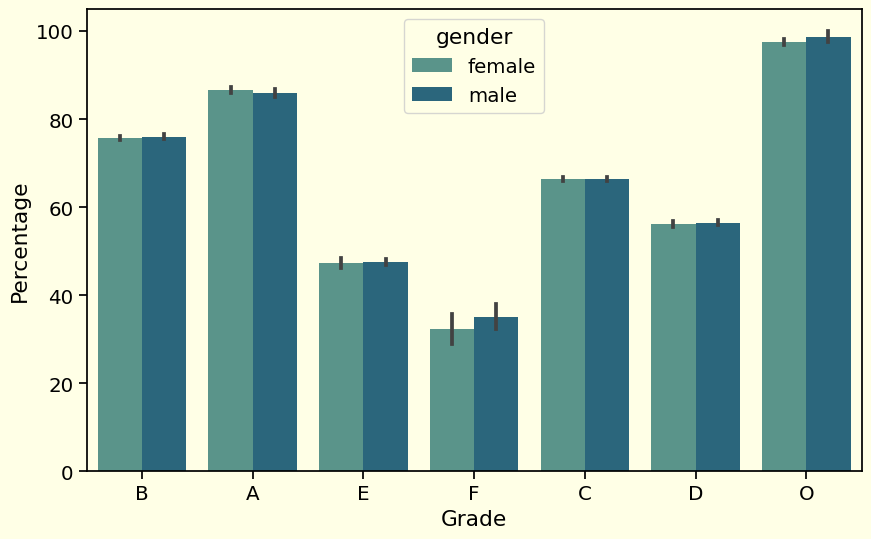

In [18]:
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Grade', y = 'Percentage', data= data, hue= 'gender', palette= 'crest');

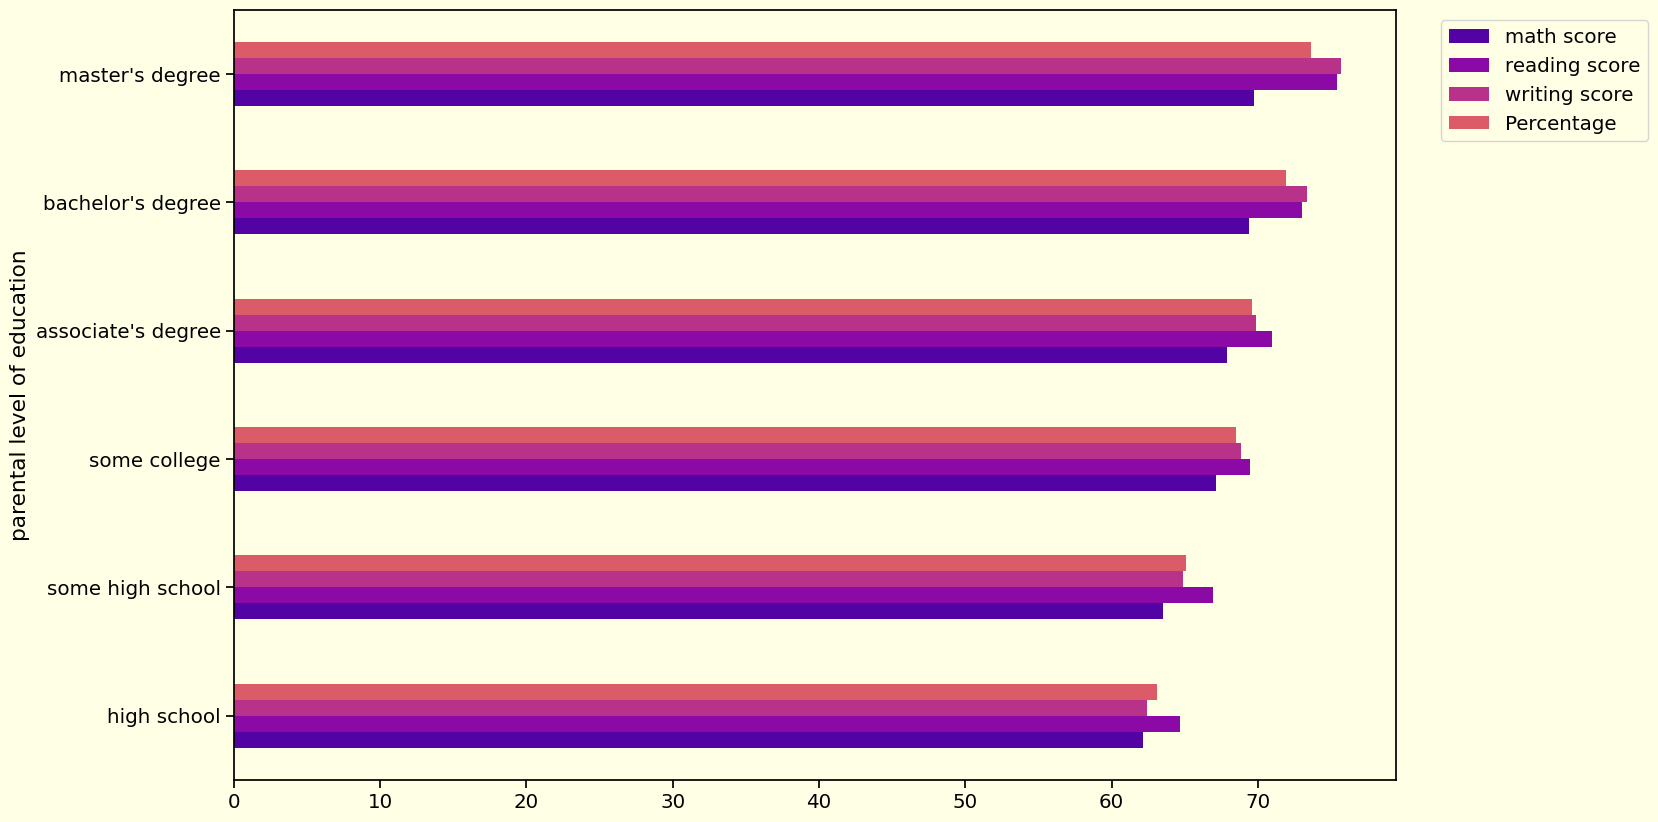

In [19]:
sns.set_palette("plasma")
data.groupby('parental level of education').agg('mean').sort_values(by = 'Percentage').plot(kind='barh',figsize=(15,10))
plt.legend(bbox_to_anchor=(1.03, 1), loc = 2);

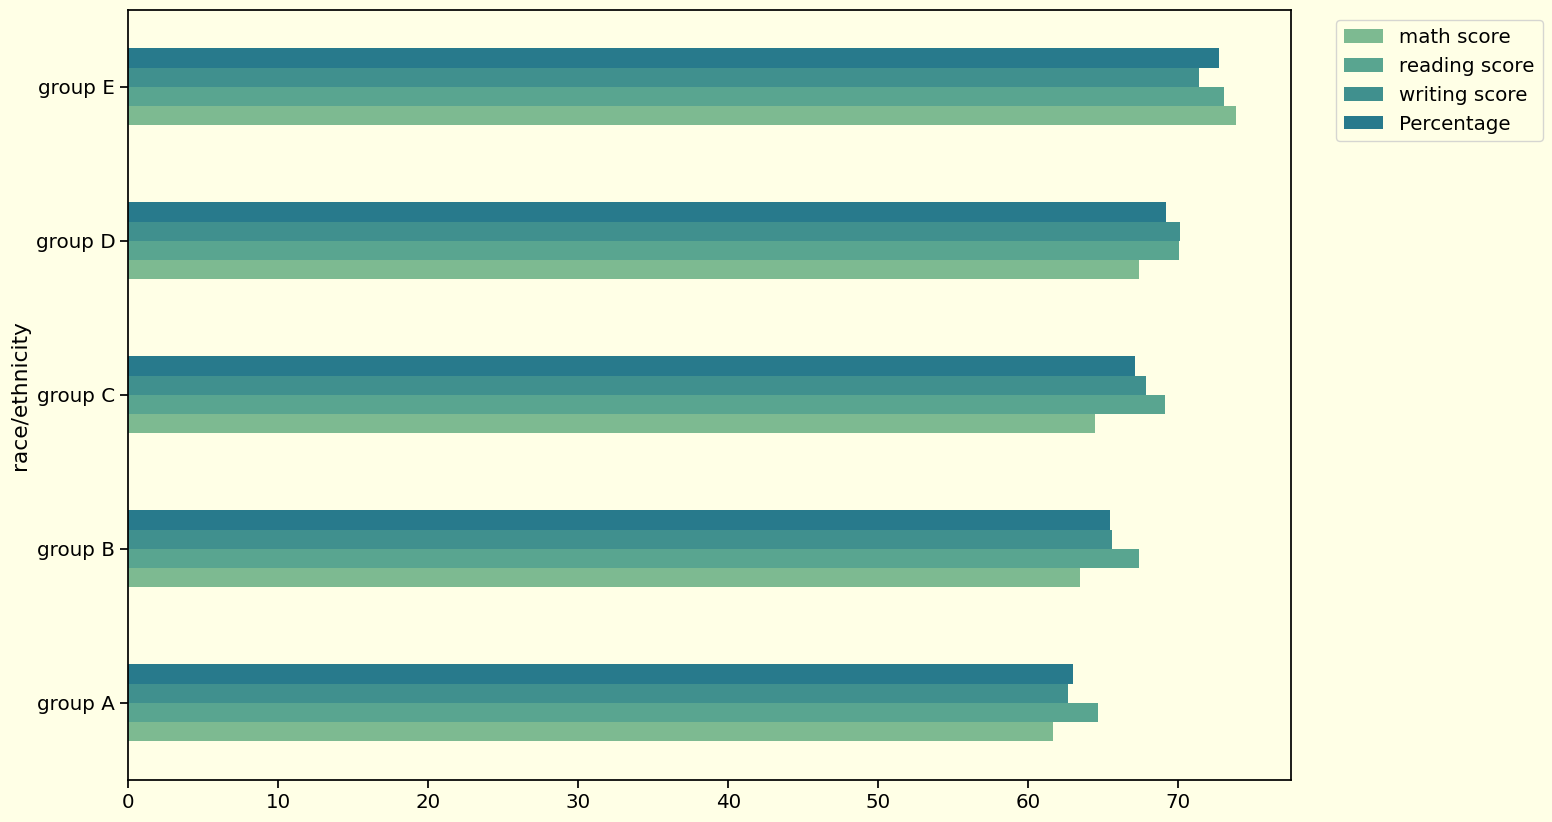

In [20]:
sns.set_palette("crest")
data.groupby('race/ethnicity').agg('mean').sort_values(by = 'Percentage').plot(kind='barh',figsize=(15,10))
plt.legend(bbox_to_anchor=(1.03, 1), loc = 2);

# ****Pipeline

In [21]:
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, grades_ordering = ['F', 'E', 'D', 'C', 'B', 'A', 'O'],
                 ethnicity_ordering = ['group A', 'group B', 'group C', 'group D', 'group E'],
                 parents_education_ordering = ['high school', 'some high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]):
                 
        self.grades_ordering = grades_ordering
        self.ethnicity_ordering = ethnicity_ordering
        self.parents_education_ordering = parents_education_ordering
    
    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X["Grade"] = X['Grade'].apply(lambda x: self.grades_ordering.index(x))
        X["parental level of education"] = X['parental level of education'].apply(lambda x: self.parents_education_ordering.index(x))
        X["race/ethnicity"] = X['race/ethnicity'].apply(lambda x: self.ethnicity_ordering.index(x))
        return X


In [22]:
num_cols = ['reading score', 'writing score', 'Percentage']
cat_cols = ['gender', 'lunch', 'test preparation course']
ordinal_cols = ['Grade', 'race/ethnicity', 'parental level of education']


In [23]:
pipeline = ColumnTransformer([
    ('std_scaler', StandardScaler(), num_cols),
    ('ord_encode', CustomOrdinalEncoder(), ordinal_cols),
    ('label_encode', OneHotEncoder(), cat_cols)], remainder= 'passthrough')

In [24]:
data['Percentage'] = round((data['reading score'] + data['writing score']) / 2, 2)
data["Grade"] = data['Percentage'].apply(lambda x: Grade(x))

# ****Data Trimmimg

In [25]:
X = data.drop('math score', axis = 1)
y = data['math score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [26]:
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

# ****Modelling

# Random Forest

In [27]:
model = RandomForestRegressor(random_state = 42)
model.fit(X_train_prepared, y_train)

kfold = KFold(n_splits= 5)
scores =  - cross_val_score(model, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=kfold)
rmse_scores = np.sqrt(scores)

print(f"Mean: {rmse_scores.mean()}", )
print(f"Standard deviation: {rmse_scores.std()}")

Mean: 6.042128125543862
Standard deviation: 0.18077648360495044


In [28]:
y_pred = model.predict(X_test_prepared)
rmse = mean_squared_error(y_test, y_pred, squared= False)
r_square = r2_score(y_test, y_pred)

In [29]:
print(f'Root Mean Squared error: {round(rmse, 3)}')
print(f'R-square: {round(r_square, 3)}')


Root Mean Squared error: 6.141
R-square: 0.845


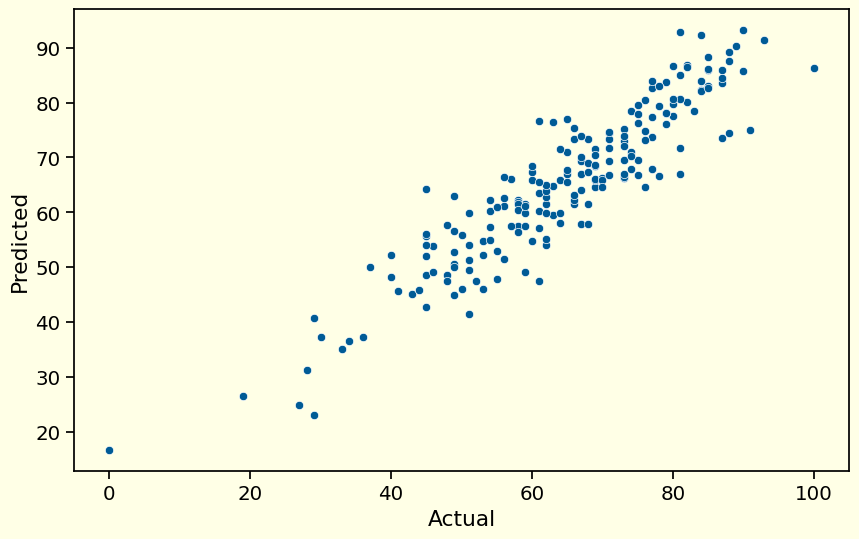

In [30]:
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test, y= y_pred, color= '#005b96')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Hyperparameter Optimization

### **GridSearchCV**

In [31]:
params = [
    {'n_estimators': [100, 250, 400], 'max_features': [8, 16, 24]},
    {'bootstrap': [False], 'n_estimators': [200, 400], 'max_features': [15, 30]},
  ]

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, params, cv = kfold,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [8, 16, 24],
                          'n_estimators': [100, 250, 400]},
                         {'bootstrap': [False], 'max_features': [15, 30],
                          'n_estimators': [200, 400]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [32]:
mean_rmse_grid_search = np.sqrt( - grid_search.best_score_)
print(f'RMSE: {round(mean_rmse_grid_search, 2)}')

RMSE: 5.95


### **RandomizedSearchCV**

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params = {
        'n_estimators': randint(low= 200, high=500),
        'max_features': randint(low=10, high=50),
    }

model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(model, params,
                                   n_iter = 10, cv = kfold, scoring='neg_mean_squared_error', random_state=42)

random_search.fit(X_train_prepared, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x792fb0903ca0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x792fb0903b80>},
                   random_state=42, scoring='neg_mean_squared_error')

In [34]:
mean_rmse_random_search = np.sqrt( - random_search.best_score_)
print(f'RMSE: {round(mean_rmse_random_search, 2)}')

RMSE: 6.0


### **Optuna**

In [36]:
def random_forest_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 600)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])  # Use actual boolean values
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        bootstrap=bootstrap
    )
    
    model.fit(X_train_prepared, y_train)
    cv_score = - cross_val_score(model, X_train_prepared, y_train, scoring='neg_mean_squared_error', cv=kfold)
    
    return np.sqrt(np.mean(cv_score))

study = optuna.create_study(direction='minimize')
study.optimize(random_forest_objective, n_trials=10)


[I 2023-08-17 14:33:49,360] A new study created in memory with name: no-name-e6ff3143-dada-44c4-9e64-33619745f70c
[I 2023-08-17 14:33:50,545] Trial 0 finished with value: 6.0529293175043355 and parameters: {'n_estimators': 108, 'max_depth': 5, 'bootstrap': True}. Best is trial 0 with value: 6.0529293175043355.
[I 2023-08-17 14:33:52,716] Trial 1 finished with value: 6.013856447152926 and parameters: {'n_estimators': 141, 'max_depth': 27, 'bootstrap': True}. Best is trial 1 with value: 6.013856447152926.
[I 2023-08-17 14:33:59,519] Trial 2 finished with value: 8.2415703978982 and parameters: {'n_estimators': 369, 'max_depth': 40, 'bootstrap': False}. Best is trial 1 with value: 6.013856447152926.
[I 2023-08-17 14:34:01,568] Trial 3 finished with value: 8.245603904940786 and parameters: {'n_estimators': 112, 'max_depth': 21, 'bootstrap': False}. Best is trial 1 with value: 6.013856447152926.
[I 2023-08-17 14:34:06,842] Trial 4 finished with value: 6.023806534821362 and parameters: {'n_es

In [38]:
trial = study.best_trial
print(f'RMSE: {round(trial.value, 2)}')

RMSE: 5.99


In [42]:
params = {
    'n_estimators': 69,
    'max_depth': 21,
    'bootstrap': 'True'
}

# Predictions

In [44]:
# Assuming you have previously defined the 'params' dictionary using Optuna or some other method
params = {
    'n_estimators': 280,
    'max_depth': 20,
    'bootstrap': True  # Use an actual boolean value here
}

final_model = RandomForestRegressor(**params)
final_model.fit(X_train_prepared, y_train)
final_predictions = final_model.predict(X_test_prepared)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rsquare = r2_score(y_test, final_predictions)


In [45]:
print(f'RMSE: {round(final_rmse, 3)}')
print(f'R-square: {round(final_rsquare, 3)}')


RMSE: 6.104
R-square: 0.847


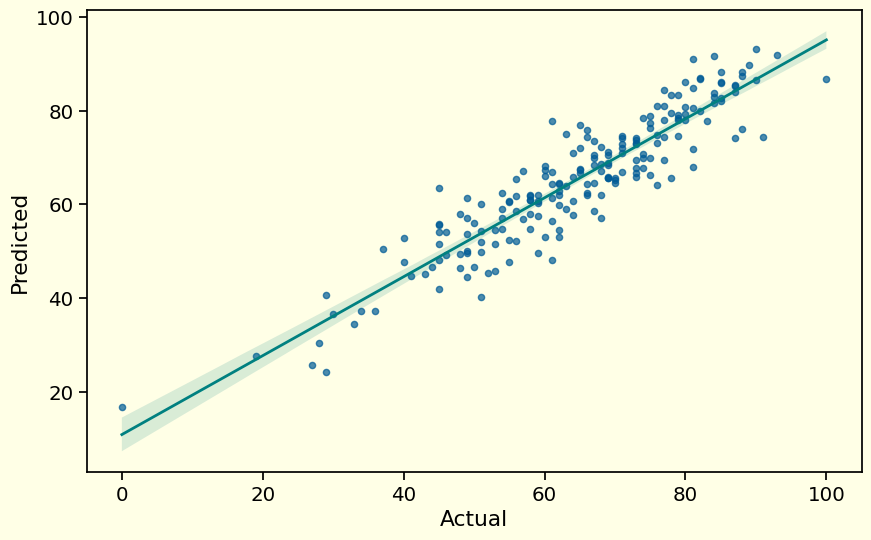

In [46]:
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize= (10, 6))
sns.regplot(x= y_test, y= final_predictions, scatter_kws = {'s': 20, 'color': '#005b96', 'alpha': 0.7}, 
            line_kws = {'linewidth': 2, 'color': 'teal'})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

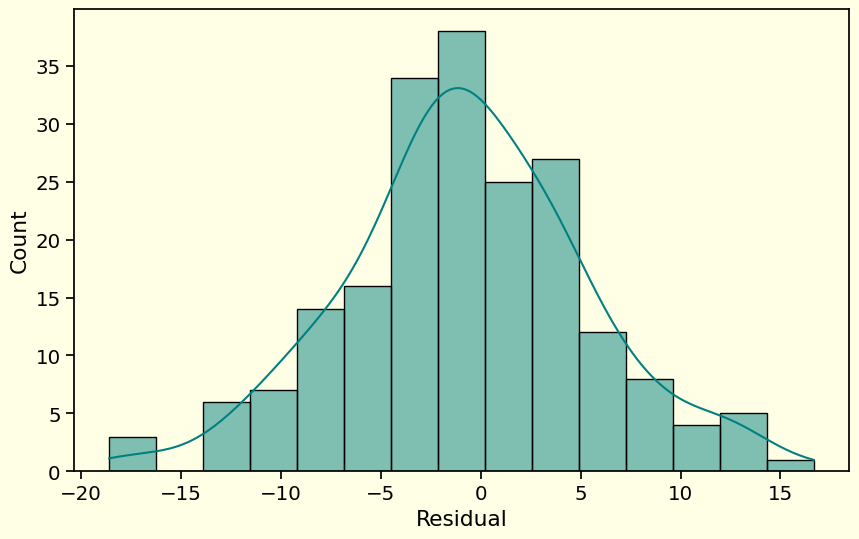

In [47]:
# Distribution of error
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize= (10, 6))
sns.histplot(y_test - final_predictions, color = 'teal', kde= True)
plt.xlabel('Residual');

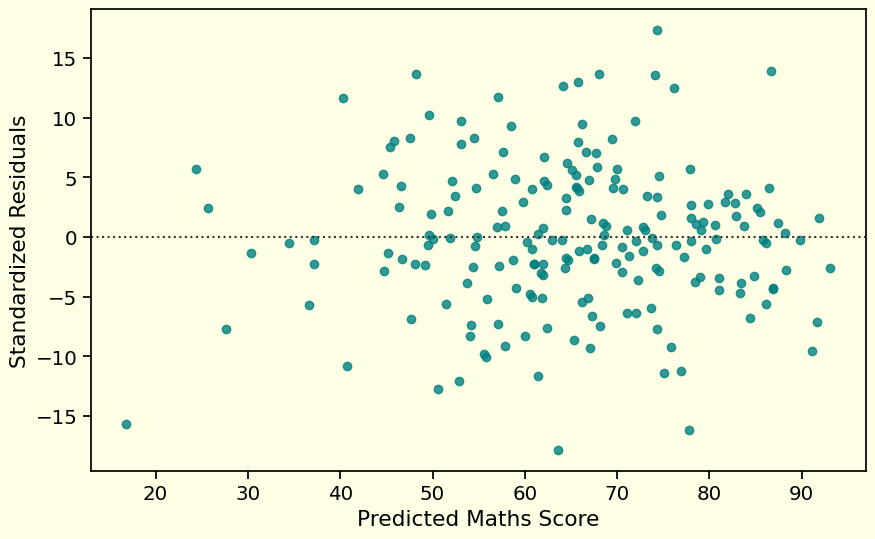

In [48]:
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize= (10, 6))
sns.residplot(x = final_predictions, y = y_test, color = 'teal')
plt.xlabel('Predicted Maths Score')
plt.ylabel('Standardized Residuals')
plt.show()